In [40]:
# !pip install tensorflow tensorflow-hub pandas nltk matplotlib tqdm seaborn

In [41]:
# A dependency of the preprocessing for BERT inputs
# !pip install -U "tensorflow-text==2.13.*"

In [42]:
# !pip install "tf-models-official==2.13.*"

In [43]:
from google.colab import drive;
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Using datatype? Don't touch. When it work, it WORKS!
# csv_data_path: str = "data.csv";
csv_data_path: str = "/content/drive/MyDrive/Collab Dataset/FIN DL/Number 3/data.csv";

# slang_data_path = "slang.txt";
slang_data_path = "/content/drive/MyDrive/Collab Dataset/FIN DL/Number 3/slang.txt";

# Sentiment Analysis on Twitter US Airline with BERT

This experimentation endeavor a sentiment analysis on Twitter US Airline data. The data originated from 2015. It was downloaded from [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment). The original source says,

> "*A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").*"

However, since the focus on this experimentation is mainly focused on Natural Language Processing (NLP), other than `airline_sentiment` and `text` will be **ignored for the model training**, but used for exploration.

The goal of this experiment is to produce a high prediction accuracy deep learning model. The work employing Tensorflow's deep learning backend with Keras's API.

The process to make the model is as follow:

1. Dataset Exploration
2. Dataset Pre-Processing
3. Dataset Loading
4. Model Architecture
5. Model Training
6. Model Evaluation

## 1. Dataset Exploration

### First statements

As per information available in Kaggle, some columns are not suit for this experimentation. Therefore, these columns below:

| No | Name |
|---|---|
| 1 | tweet_id |
| 2 | negativereason |
| 3 | airline |
| 4 | airline_sentiment_gold |
| 5 | name |
| 6 | negativereason_gold |
| 7 | retweet_count |
| 8 | tweet_coord |
| 9 | tweet_created |
| 10 | tweet_location |
| 11 | user_timezone |

are not used for explorations and training in this experiment. Leaving these columns below:

| No | Name |
|---|---|
| 1 | airline_sentiment |
| 2 | airline_sentiment_confidence |
| 3 | negativereason_confidence |
| 4 | text |

are used.

In [45]:
import pandas;

In [46]:
dataframe = pandas.read_csv(csv_data_path, index_col = False);
dataframe = dataframe.drop(columns = [
    "tweet_id",
    "negativereason",
    "airline",
    "airline_sentiment_gold",
    "name",
    "negativereason_gold",
    "retweet_count",
    "tweet_coord",
    "tweet_created",
    "tweet_location",
    "user_timezone"
]);

In [47]:
dataframe.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,text
0,neutral,1.0000,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,1.0000,@VirginAmerica and it's a really big bad thing...


### Data profile

In [48]:
print(f"Total data (tweets): {dataframe.count()}");

Total data (tweets): airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason_confidence       10522
text                            14640
dtype: int64


### 1. Check the most minimum confidence for qualitative checks
Let's see how things going on the airline_sentiment_condifence. Check why some tweet get minimum confidence for qualitative checks.

In [49]:
# Get minimum, maximum of airline_sentiment_confidence

minimum = dataframe["airline_sentiment_confidence"].min();

minimum_confidence_data = dataframe[dataframe["airline_sentiment_confidence"] == minimum];
minimum_negative_confidence_data = dataframe.where((dataframe["airline_sentiment"] == "negative") & (dataframe["negativereason_confidence"] < 0.5) & (dataframe["negativereason_confidence"] > 0.0));
minimum_negative_confidence_data = minimum_negative_confidence_data.dropna();

print("airline_sentiment_confidence");
print("======================================================================================");
print(f"Data: {minimum_confidence_data} \n\nTweet: {minimum_confidence_data['text'].values[0]}");

print("\n\n");

print("negativereason_confidence");
print("======================================================================================");
minimum_negative_confidence_data

airline_sentiment_confidence
Data:     airline_sentiment  airline_sentiment_confidence  \
989           neutral                         0.335   

     negativereason_confidence  \
989                        0.0   

                                                  text  
989  @united Thank you, ^JH, appreciate the prompt ...   

Tweet: @united Thank you, ^JH, appreciate the prompt responses--me and other passengers will be doing so.



negativereason_confidence


,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,text
15,negative,0.6842,0.3684,@VirginAmerica SFO-PDX schedule is still MIA.
20,negative,0.6705,0.3614,@VirginAmerica why are your first fares in May...
24,negative,1.0000,0.3557,@VirginAmerica you guys messed up my seating.....
73,negative,1.0000,0.3516,@VirginAmerica your airline is awesome but you...
82,negative,0.6792,0.3477,@VirginAmerica you're the best!! Whenever I (b...
...,...,...,...,...
14568,negative,1.0000,0.3555,@AmericanAir i was spoken 2 like I'm an idiot ...
14572,negative,1.0000,0.3482,"@AmericanAir When I left Orlando, I was 2nd in..."
14577,negative,0.6694,0.3451,@AmericanAir I have never on all my trips on a...
14599,negative,1.0000,0.3704,@AmericanAir @travisamex It's not the weather....


Seems like the data turns out classified as neutral. But there is appreciation words within the text that contains "Thank you". So that is why the data is classified as neutral, but the confidence level is not there to judge it entirely as neutral. Taking this random sampling, may help to reduce misleading data that may harden sentiment analysis process.

But the negative confidence level is tough. After doing some qualitative analysis, it seems like the low confidence level caused by sarcastic texts.

### 2. Boxplot analysis for confidence level

In [50]:
import matplotlib.pyplot as plt;
import seaborn;

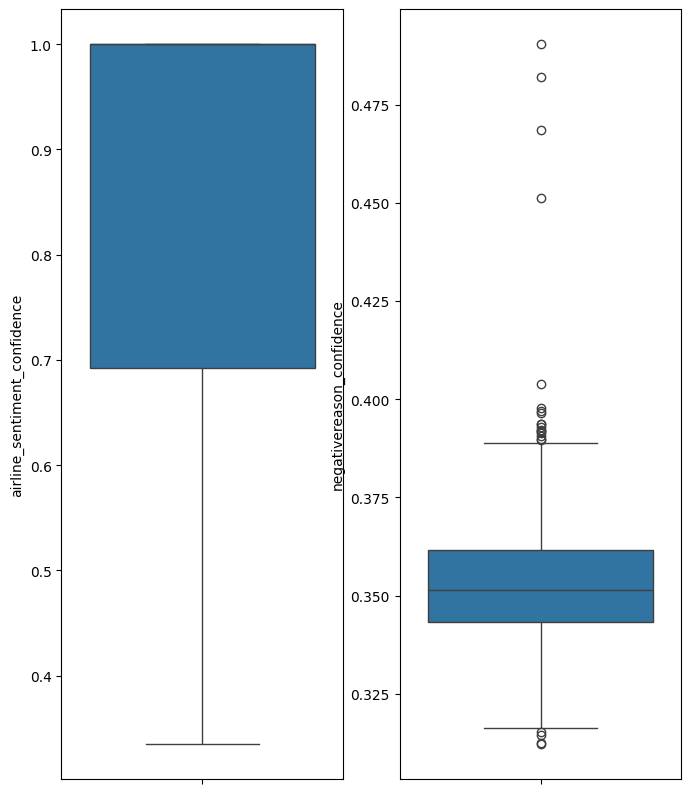

In [51]:
figure, axis = plt.subplots(ncols = 2, figsize = (8, 10)); # 20 is selected since the dimension of the data is 21, minus 1 for the label.

seaborn.boxplot(dataframe["airline_sentiment_confidence"], ax = axis[0]);
seaborn.boxplot(minimum_negative_confidence_data["negativereason_confidence"], ax = axis[1]);

## 2. Dataset Pre-Processing

Dataset pre-processing consist of two steps:

1. Based-on exploration result
2. Working with NLP dataset pre-processing pipeline

### 2.1 Pre-Processing post-exploration

Based-on data exploration, found that some data may just unfit to be load as it may cause problems with the training. The reason can be found on the upper section.
So these following constraints, will be deleted.
| No | Column | Constraints |
|---|---|---|
| 1 | airline_sentiment_confidence | Below 0.5 |
| 2 | negativereason_confidence | Below 0.325 |

In [52]:
constraints = ((dataframe["airline_sentiment_confidence"] < 0.5) | ((dataframe["airline_sentiment"] == "negative") & (dataframe["negativereason_confidence"] < 0.325)));

dataframe[constraints].index

Index([    1,   114,   142,   183,   309,   348,   349,   403,   462,   488,
       ...
       13997, 14020, 14075, 14078, 14147, 14261, 14297, 14414, 14530, 14635],
      dtype='int64', length=265)

In [53]:
dataframe = dataframe.drop(dataframe[constraints].index);

In [54]:
print(f"Total data after cleansing (tweets): {dataframe.count()}");

Total data after cleansing (tweets): airline_sentiment               14375
airline_sentiment_confidence    14375
negativereason_confidence       10257
text                            14375
dtype: int64


### 2.2 NLP Dataset Pre-Processing

NLP / NLU cases are known as not easy dataset pre-processing. <br />
Imagine converting your text into numbers just to make computer understand what you try to do. <br />
Public dataset also challenging. <br />

Enough the ranting.

#### IKUYOOOOO!!!
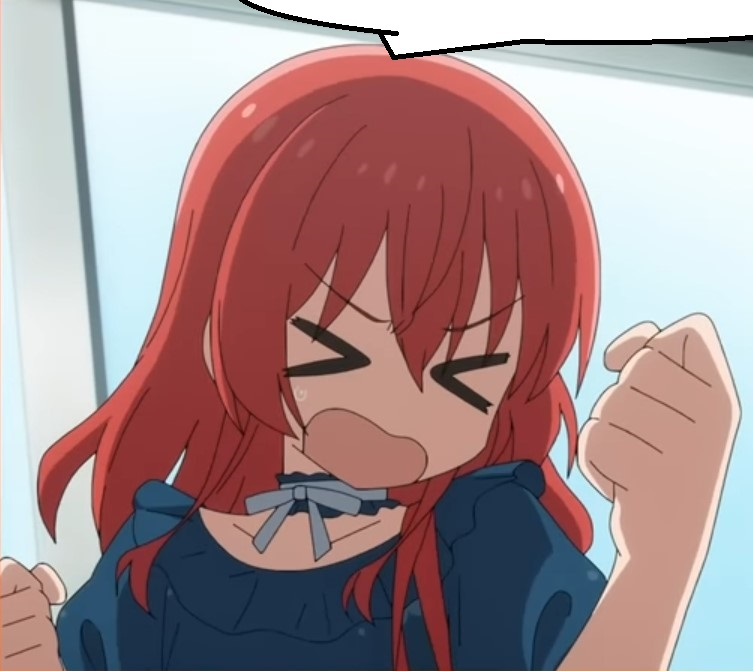

<br />
<br />
<br />

The flow of NLP dataset pre-processing for this dataset is as follows:

1. Convert the text into lowercase
2. Take out any mention tags and URI. Like @some_user_name ; https://lalala
3. Take out any punctuations
4. Take out any stop words -> Employs NLTK Stopwords dataset
5. Stemming Slang Words -> Employs https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
6. Stemming -> Employs NLTK

Anyway... Something is missing.

All of these, are going to be implemented using functional programming pattern. Why you ask? To make things easier. I want everything works like puzzle. So I implement Monad pattern that once function being called, it return something. This ease the process within dataframe process. Just see.

How things going to? Like this below:

In [55]:
import re;

import nltk;
from nltk.corpus import stopwords;
from nltk.tokenize import word_tokenize;
from nltk.stem import PorterStemmer;

from tqdm import tqdm;

In [56]:
# Define helper functions

def force_lowercase(corpus: str):
    return corpus.lower();

def uri_remover(corpus: str):
    clean_text = re.sub(r'http\S+|www\S+|https\S+', '', corpus, flags=re.MULTILINE);

    return clean_text;

def mention_tags_remover(corpus: str):
    clean_text = re.sub(r'\@\w+|\#','', corpus);

    return clean_text;

def punctuation_remover(corpus: str):
    clean_text = re.sub(r'[^\w\s]', "", corpus);
    return clean_text;

# Slang Stemmer
slang_db = {}
with open(slang_data_path, 'r') as file:
    for line in file:
        key, value = line.split('=');
        slang_db[key] = value;

def slang_corpus_stemmer(corpus: str):
    words = corpus.split();

    clean_words = [slang_db.get(i, i) for i in words];

    return " ".join(clean_words);

# Initialize NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english');
def stop_words_remover(corpus: str):
    words = corpus.split();

    clean_words = [i for i in words if i not in stop_words];

    return " ".join(clean_words);

# Initlaize Stemmer
stemmer = PorterStemmer();
def corpus_stemmer(corpus: str):
    words = corpus.split();

    clean_words = [stemmer.stem(token) for token in words];

    return " ".join(clean_words);

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# Let's separate the feature from label first
untouched_tweets = dataframe["text"];
label = dataframe["airline_sentiment"];

In [58]:
# This part is where we use functions above.

tqdm.pandas();

print("Convert the text into lowercase - ", end = " ");
corpus = untouched_tweets.progress_apply(lambda x: force_lowercase(x));

print("Take out any URI - ", end = " ");
corpus = corpus.progress_apply(lambda x: uri_remover(x));

print("Take out any mention tags - ", end = " ");
corpus = corpus.progress_apply(lambda x: mention_tags_remover(x));

print("Take out any punctuations - ", end = " ");
corpus = corpus.progress_apply(lambda x: punctuation_remover(x));

print("Take out any stop words - ", end = " ");
corpus = corpus.progress_apply(lambda x: stop_words_remover(x));

print("Stemming Slang Words - ", end = " ");
corpus = corpus.progress_apply(lambda x: slang_corpus_stemmer(x));

print("Stemming - ", end = " ");
stemmed_corpus = corpus.progress_apply(lambda x: corpus_stemmer(x));

Convert the text into lowercase -  

100%|██████████| 14375/14375 [00:00<00:00, 738144.51it/s]


Take out any URI -  

100%|██████████| 14375/14375 [00:00<00:00, 287018.52it/s]


Take out any mention tags -  

100%|██████████| 14375/14375 [00:00<00:00, 322409.31it/s]


Take out any punctuations -  

100%|██████████| 14375/14375 [00:00<00:00, 231483.51it/s]


Take out any stop words -  

100%|██████████| 14375/14375 [00:00<00:00, 31990.10it/s]


Stemming Slang Words -  

100%|██████████| 14375/14375 [00:00<00:00, 304827.85it/s]


Stemming -  

100%|██████████| 14375/14375 [00:02<00:00, 6024.68it/s]


In [59]:
stemmed_corpus

0                                                     said
2               didnt today must mean need take anoth trip
3        realli aggress blast obnoxi entertain guest fa...
4                                     realli big bad thing
5        serious would pay 30 flight seat didnt play re...
                               ...                        
14634                                      right cue delay
14636    leav 20 minut late flight warn commun 15 minut...
14637             pleas bring american airlin blackberry10
14638    money chang flight dont answer phone suggest m...
14639    8 ppl need 2 know mani seat next flight plz pu...
Name: text, Length: 14375, dtype: object

## 3. Data Loading

Now with we got the stemmed data, we can now starts the data loading. There are several things that need to be done:

1. Perform One-Hot Encoding to the labels
2. Train-Test-Val Split

The Train-Test-Val splits follow the segmentation below:
70:15:15

In [60]:
from sklearn.model_selection import train_test_split;
import numpy;

In [61]:
one_hot_labels = [];
one_hot_labels = pandas.get_dummies(label, prefix = "label");
one_hot_labels = one_hot_labels.to_numpy().astype('float32');

In [62]:
train_corpus, test_corpus, train_label, test_label = train_test_split(stemmed_corpus, one_hot_labels, train_size = 0.7, test_size = 0.3);
test_corpus, val_corpus, test_label, val_label = train_test_split(test_corpus, test_label, train_size = 0.5, test_size = 0.5);

len(train_corpus), len(train_label), len(test_corpus), len(test_label), len(val_corpus), len(val_label)

(10062, 10062, 2156, 2156, 2157, 2157)

## 4. Model Architecture

Before jumping into the actual model, a little step of pre-processing using Bidirectional Encoder Representations from Transformers (BERT) is necessary. This include tokenization, and vectorization. Yes you're not wrong when you can tell that something was missing on the functional helper part. Because, this part are handled using BERT.

The special thing is, this part employed Tensorflow Hub. Tensorflow's model zoo repository. [Check this out](https://www.tensorflow.org/text/tutorials/classify_text_with_bert).

What this part gonna do are:

1. Load BERT model (Small BERT 512)
2. Tokenize & Vectorize all Train-Test-Val data
3. Define Model Architecture (Yes the OOP thingy again)

In [63]:
import tensorflow;
import tensorflow_hub;
import tensorflow_text as text;

In [64]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-6_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [65]:
bert_preprocess_model = tensorflow_hub.KerasLayer(tfhub_handle_preprocess);
bert_model = tensorflow_hub.KerasLayer(tfhub_handle_encoder);

In [66]:
vectorized_train_corpus = bert_preprocess_model(train_corpus);
vectorized_test_corpus = bert_preprocess_model(test_corpus);
vectorized_val_corpus = bert_preprocess_model(val_corpus);

In [67]:
# vectorized_train_corpus

In [68]:
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda;
from tensorflow.keras.models import Sequential, Model;
from tensorflow.keras.optimizers import Adam, SGD;
from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;
from tensorflow.keras.regularizers import l2, l1_l2;
from tensorflow.data import Dataset;

import matplotlib.pyplot as plt;

from tensorflow_hub import KerasLayer;

In [69]:
train_set_loader = Dataset.from_tensor_slices((vectorized_train_corpus, train_label));
test_set_loader = Dataset.from_tensor_slices((vectorized_test_corpus, test_label));
val_set_loader = Dataset.from_tensor_slices((vectorized_val_corpus, val_label));

In [74]:
vectorized_train_corpus.keys()

# vectorized_train_corpus["input_type_ids"].shape

dict_keys(['input_mask', 'input_type_ids', 'input_word_ids'])

In [80]:
# Model Architecture. Oh yeah. Here we go again...
class BERTModel():
    def __init__(self):
        self.model_name = "bert.202405310722";
        self.encoder = bert_model;
        self.dropout = Dropout(0.1);
        self.output = Dense(3, activation="softmax");

    def init_build(self):
        input_word_ids = Input(shape=(None,), dtype=tensorflow.int32, name='input_word_ids');
        input_mask = Input(shape=(None,), dtype=tensorflow.int32, name='input_mask');
        input_type_ids = Input(shape=(None,), dtype=tensorflow.int32, name='input_type_ids');

        inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        };

        encoder_output = self.encoder(inputs);
        net = self.dropout(encoder_output['pooled_output']);
        net = self.output(net);

        model = Model(inputs=inputs, outputs=net, name=self.model_name);
        return model;

    # Early stopping after loss are not improved for some epochs
    def _callback_early_stopping(self):
        early_stopping_tolerance = 5;
        return EarlyStopping(
            monitor = "val_loss",
            patience = early_stopping_tolerance,
            restore_best_weights = True
        );

    def fitting(self):
        model = self.init_build();

        model.compile(optimizer = Adam(learning_rate = 1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"]);
        model.summary();

        plot_model(model, to_file = (f"model_architecture.{self.model_name}.png"), show_shapes = True);

        history = model.fit(
            vectorized_train_corpus,
            train_label,
            epochs = 10,
            batch_size = 64,
            validation_data = (vectorized_val_corpus, val_label),
            callbacks = [self._callback_early_stopping()]
        );

        # Plot training history
        plt.figure(figsize=(15, 12))

        # Loss
        plt.subplot2grid((3, 2), (0, 0));
        plt.plot(history.history['loss'], label='Training Loss');
        plt.plot(history.history['val_loss'], label='Validation Loss');
        plt.title('Loss Plots');
        plt.xlabel('Epoch');
        plt.ylabel('Loss');
        plt.legend();

        # Accuracy
        plt.subplot2grid((3, 2), (0, 1));
        plt.plot(history.history['accuracy'], label='Training Accuracy');
        plt.plot(history.history['accuracy'], label='Validation Accuracy');
        plt.title('Binary Accuracy Plots');
        plt.xlabel('Epoch');
        plt.ylabel('Binary Accuracy');
        plt.legend();

        plt.tight_layout();
        plt.show();

        return model;

## 5 & 6. Model Training & Evaluation

Yes. Train it. Evaluate it.

In [72]:
# Helper Function
import requests;
import time;

# telegram_reporter
"""
This function helps to send message to telegram private channel
"""
def telegram_reporter(message):
    message = "[" + time.strftime("%Y-%m-%d %H:%M:%S") +"][CNN FROM SCRATCH] " + message
    requests.request(
        method="POST",
        url="https://api.telegram.org/bot6307342709:AAEehfQrvZzQhk2hFlOW7C1JnE2hRQYLEgE/sendMessage?chat_id=-1001525528850&text=" + message,
        headers={},
        data={}
    );

In [ ]:
# telegram_reporter("Starting training");

cnn = BERTModel();
model = cnn.fitting();

test_loss, test_acc = model.evaluate(test_corpus, test_label)
print(f'Test accuracy: {test_acc}')

telegram_reporter("Training done");

Model: "bert.202405310722"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 input_word_ids (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                  